In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

np.random.seed(142)

In [2]:
ticker = 'CL=F'

data = yf.download(ticker, start='2022-01-01', end='2025-04-07', progress=False)
close_prices = data['Close']

returns = close_prices.pct_change().dropna()
sigma = (returns.std() * np.sqrt(252)).values

YF.download() has changed argument auto_adjust default to True


In [3]:
S0 = close_prices.iloc[-1].values
K = 65
T = 1
num_steps = 252
r = 0.0425
n_sims = 10_000

## Ejercicio 1: Funciones

In [4]:
def simulate_prices(S0, r, sigma, T, num_steps, n_sims):
    dt = T / num_steps
    Z = np.random.normal(size=(n_sims, num_steps))
    simulated_returns = (r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z

    simulated_cumulative_returns = np.cumsum(simulated_returns, axis=1)
    simulated_prices = S0 * np.exp(simulated_cumulative_returns)
    return simulated_prices

def get_price__fixed_strike__average_price(simulated_prices, K, r, T, option_type: str):
    avg_prices = np.mean(simulated_prices[:, 1:], axis=1)
    if option_type == 'call':
        payoff = np.maximum(avg_prices - K, 0)
    elif option_type == 'put':
        payoff = np.maximum(K - avg_prices, 0)

    option_price =  np.exp(-r * T) * np.mean(payoff)

    return option_price

def get_price__floating_strike__average_price(simulated_prices, ST, r, T, option_type: str):
    avg_prices = np.mean(simulated_prices[:, 1:], axis=1)
    if option_type == 'call':
        payoff = np.maximum(ST - avg_prices, 0)
    elif option_type == 'put':
        payoff = np.maximum(avg_prices - ST, 0)

    option_price = np.exp(-r * T) * np.mean(payoff)

    return option_price


def get_price__fixed_strike__geometric_price(simulated_prices, K, r, T, option_type: str):
    geometric_prices = np.exp(np.mean(np.log(simulated_prices[:, 1:]), axis=1))
    if option_type == 'call':
        payoff = np.maximum(geometric_prices - K, 0)
    elif option_type == 'put':
        payoff = np.maximum(K - geometric_prices, 0)

    option_price = np.exp(-r * T) * np.mean(payoff)

    return option_price

def get_price__floating_strike__geometric_price(simulated_prices, ST, r, T, option_type: str):
    geometric_prices = np.exp(np.mean(np.log(simulated_prices[:, 1:]), axis=1))
    if option_type == 'call':
        payoff = np.maximum(ST - geometric_prices, 0)
    elif option_type == 'put':
        payoff = np.maximum(geometric_prices - ST, 0)

    option_price = np.exp(-r * T) * np.mean(payoff)

    return option_price

def get_price__european(simulated_prices, K, r, T, option_type: str):
    ST = simulated_prices[:, -1]
    if option_type == 'call':
        payoff = np.maximum(ST - K, 0)
    elif option_type == 'put':
        payoff = np.maximum(K - ST, 0)

    option_price = np.exp(-r * T) * np.mean(payoff)

    return option_price

In [5]:
simulated_prices = simulate_prices(S0, r, sigma, T, num_steps, n_sims)
ST = np.mean(simulated_prices[:, -1])

In [6]:
get_price__fixed_strike__average_price(simulated_prices, K, r, T, 'call')

4.582557432060637

In [7]:
get_price__floating_strike__average_price(simulated_prices, ST, r, T, 'call')

6.03461514555971

In [8]:
get_price__fixed_strike__geometric_price(simulated_prices, K, r, T, 'call')

4.212219727870597

In [9]:
get_price__floating_strike__geometric_price(simulated_prices, ST, r, T, 'call')

6.357271425344086

In [10]:
get_price__european(simulated_prices, K, r, T, 'call')

8.93703856357486

## Ejercicio 2: Fixed Strikes

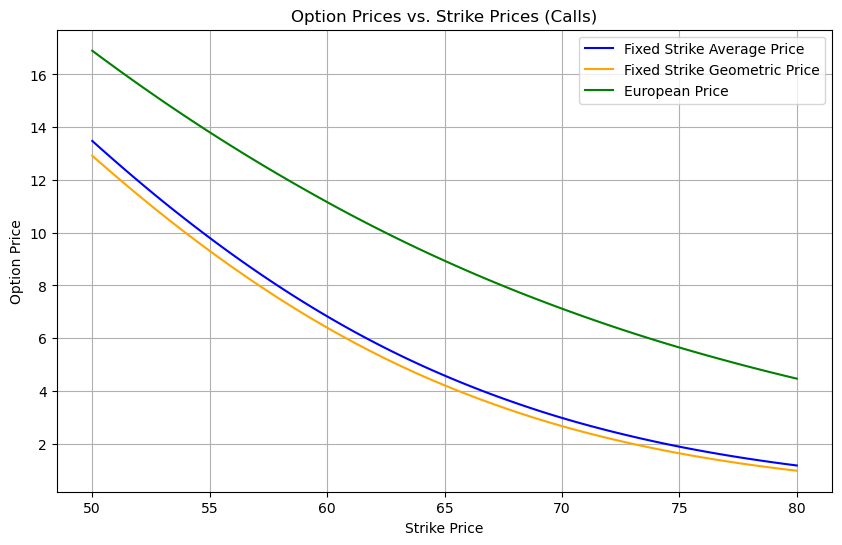

In [11]:
strikes = np.linspace(50, 80, 100)

fs_avg_price = [get_price__fixed_strike__average_price(simulated_prices, K, r, T, 'call') for K in strikes]
fs_geom_price = [get_price__fixed_strike__geometric_price(simulated_prices, K, r, T, 'call') for K in strikes]
eu_price = [get_price__european(simulated_prices, K, r, T, 'call') for K in strikes]

plt.figure(figsize=(10, 6))
plt.plot(strikes, fs_avg_price, label='Fixed Strike Average Price', color='blue')
plt.plot(strikes, fs_geom_price, label='Fixed Strike Geometric Price', color='orange')
plt.plot(strikes, eu_price, label='European Price', color='green')
plt.title('Option Prices vs. Strike Prices (Calls)')
plt.xlabel('Strike Price')
plt.ylabel('Option Price')
plt.legend()
plt.grid()
plt.show()

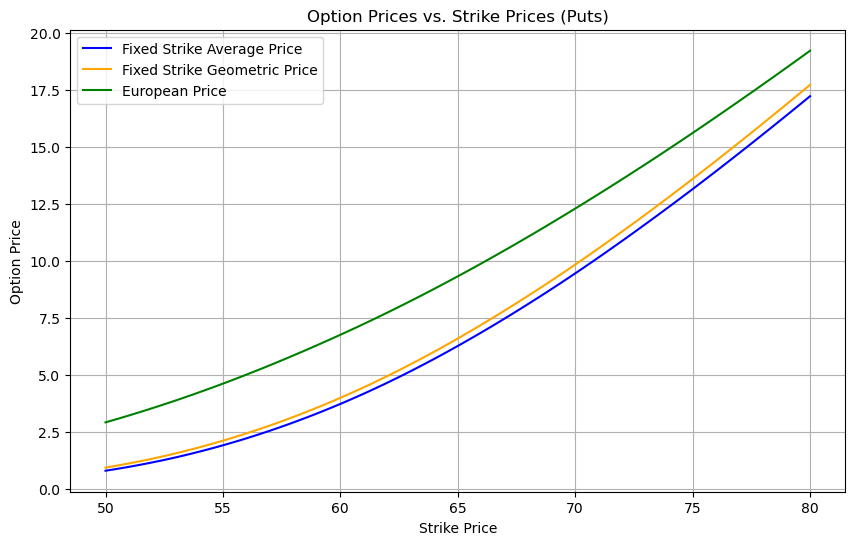

In [12]:
strikes = np.linspace(50, 80, 100)

fs_avg_price = [get_price__fixed_strike__average_price(simulated_prices, K, r, T, 'put') for K in strikes]
fs_geom_price = [get_price__fixed_strike__geometric_price(simulated_prices, K, r, T, 'put') for K in strikes]
eu_price = [get_price__european(simulated_prices, K, r, T, 'put') for K in strikes]

plt.figure(figsize=(10, 6))
plt.plot(strikes, fs_avg_price, label='Fixed Strike Average Price', color='blue')
plt.plot(strikes, fs_geom_price, label='Fixed Strike Geometric Price', color='orange')
plt.plot(strikes, eu_price, label='European Price', color='green')
plt.title('Option Prices vs. Strike Prices (Puts)')
plt.xlabel('Strike Price')
plt.ylabel('Option Price')
plt.legend()
plt.grid()
plt.show()

Usando calls, la más barata es la opción asiática con promedio geométrico, de ahí la que usa promedio aritmético y por último la más cara es la opción europea convencional. Vemos que a medida que sube el strike price el precio de las opciones baja.

Al ser opciones put las más barata es la asiática de promedio aritmético, después la de media geométrica y por último la más cara es nuevamente la opción europea normal. Vemos que mientras sube el strike price, el precio de las opciones sube.

## Ejercicio 3: Floating Strikes

In [13]:
fls_avg_price = get_price__floating_strike__average_price(simulated_prices, ST, r, T, 'call')
fls_geom_price = get_price__floating_strike__geometric_price(simulated_prices, ST, r, T, 'call')
eu_price = get_price__european(simulated_prices, ST, r, T, 'call')

fls_avg_price_put = get_price__floating_strike__average_price(simulated_prices, ST, r, T, 'put')
fls_geom_price_put = get_price__floating_strike__geometric_price(simulated_prices, ST, r, T, 'put')
eu_price_put = get_price__european(simulated_prices, ST, r, T, 'put')

calls = pd.DataFrame({
    'Floating Strike Average Price': fls_avg_price,
    'Floating Strike Geometric Price': fls_geom_price,
    'European Price': eu_price
}, index=[0])

puts = pd.DataFrame({
    'Floating Strike Average Price': fls_avg_price_put,
    'Floating Strike Geometric Price': fls_geom_price_put,
    'European Price': eu_price_put
}, index=[0])

In [14]:
calls

,Floating Strike Average Price,Floating Strike Geometric Price,European Price
0,6.034615,6.357271,9.100555


In [15]:
puts

,Floating Strike Average Price,Floating Strike Geometric Price,European Price
0,4.737502,4.362332,9.100555


Para opciones call la más cara es la opción europea, la más barata es la asiática de promedio aritmético, y en medio quedo la de media gométrica.

Para las opciones put, la más cara es la opción europea, la más barata es ahora la asiática de media geométrica, mientras que 